In [1]:
import lzma
import re
from collections import defaultdict
from pathlib import Path

import pandas as pd
import numpy as np
from natsort import natsorted
from readpaf import parse_paf
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from tqdm.notebook import tqdm

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
def get_group(file, pattern, default="unknown"):
    group = re.search(pattern, file.name)
    if group is not None:
        group = group.group(1)
    else:
        group = default
    return group

In [4]:
def read_paf_file(f):
    f = str(f)
    with lzma.open(f, "rt") as fh:
        df = parse_paf(fh, dataframe=True)
    return df

def filter_paf_df(df):
    df["map_start"] = np.where(df['strand'].eq("+"), df["target_start"], df['target_end'])
    return df[
        df["mapping_quality"].gt(20) 
        & df["tp"].eq("P") 
        & ~df["query_name"].duplicated()
    ]

In [5]:
def paf_to_targets_dict(paf_df, remove=None, sort=True):
    """Take a PAF DataFrame with columns `target_name' 
    and `target_length' and return an ordered dict of 
    targets and their lengths.
    """
    remove = [] if remove is None else remove
    remove = [remove] if isinstance(remove, str) else remove
    chrs = dict(paf_df[["target_name", "target_length"]].drop_duplicates(keep="first").itertuples(index=False))
    for chrom in remove:
        _ = chrs.pop(chrom, 0)
    if sort:
        chrom_order = natsorted(chrs.keys())
        chrs = dict(sorted(chrs.items(), key=lambda t: chrom_order.index(t[0])))
    return chrs

In [6]:
def add_panel_label(
    letter: str, 
    text_font_dict: dict, 
    axy, 
    x_offset : float = -0.03,
    y_offset: float = 1.07
) -> None:
    """
    Add the panel label (ABC) to the first axes in the Subplots
    """
    axy.text(
        x_offset, y_offset, letter,
        horizontalalignment='center',
        verticalalignment='center',
        fontdict=text_font_dict,
        transform=axy.transAxes
    )

This might take a while, there's a lot of data

In [7]:
files = defaultdict(list)
for f in Path("chunked_pafs").rglob("*.xz"):
    group = get_group(f, r"^(.*)_")
    files[group].append(read_paf_file(f))

In [8]:
files = {
    f: filter_paf_df(pd.concat(dfs))
    for f, dfs in files.items()
}

  0%|                                                                                                         …

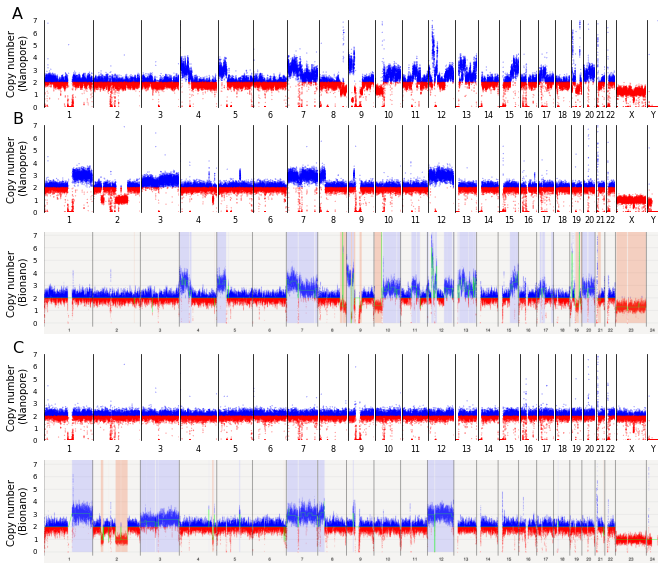

In [9]:
bin_size = 50_000
grid_ylab = "Copy number"
grid_ycol = "ploidy"
grid_ylim = (0, 8)
grid_fig_size = (11, 10)
xcol = "bin"
grid_file_ext = "pdf"
plot_kws = {"x": xcol, "y": grid_ycol, "marker": "."}

fig = plt.figure(figsize=grid_fig_size)
# Make the plot
fig.set_facecolor("white")
chrs = paf_to_targets_dict(files["barcode01"], remove="chrM")
# grid spec 5 rows, 1 column, height ratios (1.21) so the png fills the whole axis
gs0 = gridspec.GridSpec(5, 1, figure=fig, height_ratios=[1, 1, 1.21, 1, 1.21])
gs0.tight_layout(fig)
gs_title_font_dict = {"fontsize": 16, "ha": "center"}

# sub gridspecs for the 3 panels we are drawing from nanopore paf data
sub_gs_kwargs = {"ncols": len(chrs), "nrows": 1, "width_ratios": chrs.values(), "wspace": 0.025}

gs01 = gs0[0].subgridspec(**sub_gs_kwargs)
gs02 = gs0[1].subgridspec(**sub_gs_kwargs)
gs04 = gs0[3].subgridspec(**sub_gs_kwargs)

# create all 5 axes for our panels, 3 (1st, 2nd, 4th) are generators yielding 
#   axes for each contig of nanopore data, 2 are single axes to put the PNG on
axs_1st = (fig.add_subplot(gs01[i]) for i in range(len(chrs)))
axs_2nd = (fig.add_subplot(gs02[i]) for i in range(len(chrs)))
axs_3rd = fig.add_subplot(gs0[2])
axs_4th = (fig.add_subplot(gs04[i]) for i in range(len(chrs)))
axs_5th = fig.add_subplot(gs0[4])

# progress bar
prog = tqdm(files.items(), dynamic_ncols=True)
nanopore_axes = (axs_1st, axs_2nd, axs_4th)
bionano_axes = (axs_3rd, axs_5th)
# PNGs from bionano browser
bionano_images = ("NB4_cropped_cnv.png", "22Rv1_cropped_cnv.png")
panel_labels = iter(("A", "B", "C"))

# enumerate paf dfs
for j, (file, df) in enumerate(prog):
    file = ".".join(file.split('.')[:-1])
    # Create bins, aggregate data, normalise to expected copy
    df["bin"] = df["map_start"].floordiv(bin_size)
    plot_df = df.groupby(["target_name", "bin"], as_index=False).size()
    plot_df["ploidy"] = plot_df["size"] / plot_df["size"].median() * 2

    # Get targets for this PAF file
    chrs = paf_to_targets_dict(df, remove="chrM")

    for i, (ax, target) in enumerate(zip(nanopore_axes[j], chrs.keys())):
        target_length = chrs.get(target)
        assert target_length is not None, "This shouldn't happen"

        # Subset data
        tmpdf = plot_df[plot_df["target_name"].eq(target) & plot_df[grid_ycol].between(*grid_ylim)]

        # Fill missing bins
        expected_min = 0
        expected_max = (target_length // bin_size) + 1
        # Create new index with all expected bins, apply that. 
        #   See: https://stackoverflow.com/a/25916109
        new_index = pd.Index(np.arange(expected_min, expected_max, 1), name=xcol)
        tmpdf = tmpdf.set_index(xcol).reindex(new_index).reset_index()
        # These maybe unnecessary 
        tmpdf["target_name"] = tmpdf["target_name"].fillna(target)
        tmpdf = tmpdf.fillna(0)

        # Generate colours array
        colors = (tmpdf[grid_ycol].gt(2)).map({True: "blue", False: "red"}).to_numpy()
        # Plot
        tmpdf.plot.scatter(c=colors, ax=ax, **plot_kws, s=0.1)
        ax.set_xmargin(0.01)
        
        # Despine
        for side in ["top", "bottom", "right"]:
            ax.spines[side].set_visible(False)
        # if not first col remove y axis labels
        if not ax.get_subplotspec().is_first_col():
            ax.yaxis.set_visible(False)
        else:
            ax.set_ylabel(f"{grid_ylab}\n (Nanopore)", fontsize="medium")
            add_panel_label(next(panel_labels), gs_title_font_dict, ax, x_offset=-0.55)
        # fixed y lim for each contig axes
        ax.set_ylim(0,7)        
        # Remove x/y ticks
        ax.tick_params(bottom=False, left=False, labelbottom=False)
        target = target.lstrip("chr")
        ax.set_yticks(np.arange(min(ax.get_ylim()), max(ax.get_ylim())+1/7, (sum(ax.get_ylim())) / 7))
        # force 0-7 on axes (mpl scaled down at this in steps of 2, 0-6 )
        ax.set_yticklabels(range(0,8,1), fontsize=7)
        ax.xaxis.set_label_text(target, fontdict={"fontsize": 8})

# now append bionano pngs
for (ax, im) in zip(bionano_axes, bionano_images):
    img = plt.imread(im)
    ax.imshow(img)
    # fully despine
    for side in ["top", "bottom", "right", "left"]:
        ax.spines[side].set_visible(False)
    # remove x/y ticks
    ax.tick_params(bottom=False, left=False, labelbottom=False)
    ax.set_ylabel(f"{grid_ylab}\n (Bionano)", fontsize="medium")
    # unintutively and wierdly going top down, set ticks so they match up with the png lines, 
    #   done in something resembling pixels, eyeballometrically
    ax.set_yticks(np.arange(min(ax.get_ylim())+11, (max(ax.get_ylim())-30), (sum(ax.get_ylim())-45) / 7))
    ax.set_yticklabels(range(7,-1,-1), fontsize=7)
    
fig.savefig(
    f"copy-number-bio-nano-grid-spec-bins.{grid_file_ext}", 
    dpi=300, facecolor="w", 
    transparent=False, 
    bbox_inches="tight",
)